In [1]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [6]:
raw_num = 240
col_num = 2000

class Data(object):
    
    def __init__(self):
        self.data = self.get_data()
        self.label = self.get_label()
        
    def file_list(self):
        return os.listdir('C:/Users/Dev/Documents/cnn lstm model/baer_fault_diagnosis-master/data/')
    
    def get_data(self):
        file_list = self.file_list()
        for i in range(len(file_list)):
            file = scio.loadmat('C:/Users/Dev/Documents/cnn lstm model/baer_fault_diagnosis-master/data/{}'.format(file_list[i]))
            for k in file.keys():
                file_matched = re.match('X\d{3}_DE_time', k)
                if file_matched:
                    key = file_matched.group()
            if i == 0:
                data = np.array(file[key][0:480000].reshape(raw_num,col_num))
            else:
                data = np.vstack((data, file[key][0:480000].reshape((raw_num,col_num))))
        return data
    
    def get_label(self):
        file_list = self.file_list()
        title = np.array([i.replace('.mat', '') for i in file_list])
        label = title[:, np.newaxis]
        label_copy = np.copy(label)
        for _ in range(raw_num-1):
            label = np.hstack((label, label_copy))
        return label.flatten()

In [7]:
Data = Data()
data = Data.data
label = Data.label
lb = LabelBinarizer()
y = lb.fit_transform(label)

# Wiener filtering
data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)

# downsampling
index = np.arange(0,2000, 8)
data_samp = data_wiener[:, index]
print(data_samp.shape)

(2400, 250)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def built_model():
    input_seq = Input(shape=(250,))
    X = Reshape((250, 1))(input_seq)
    
    # encoder1
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,
                       padding='valid', activation='tanh')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh')(ec1_layer1)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec1_layer2)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh')(ec2_layer4)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec2_layer5)
    
    encoder = multiply([ec1_outputs, ec2_outputs])
    
    dc_layer1 = LSTM(60, return_sequences=True)(encoder)
    dc_layer2 = LSTM(60)(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)
    
    model = Model(input_seq, dc_layer4)
    
    return model

In [10]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [11]:
import time
begain_time = time.time()

In [12]:
model = built_model()
opt = Adam(learning_rate=0.0006)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 250, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 245, 50)      350         ['reshape[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 240, 40)      12040       ['conv1d_2[0][0]']               
                                                                                              

In [13]:
history = model.fit(x=X_train, y=y_train, batch_size=100, epochs=400, 
                    verbose=2, validation_data=(X_test, y_test),
                    shuffle=True, initial_epoch=0)

Epoch 1/400
17/17 - 8s - loss: 0.0896 - accuracy: 0.1345 - val_loss: 0.0885 - val_accuracy: 0.0889 - 8s/epoch - 465ms/step
Epoch 2/400
17/17 - 2s - loss: 0.0848 - accuracy: 0.1435 - val_loss: 0.0818 - val_accuracy: 0.1875 - 2s/epoch - 103ms/step
Epoch 3/400
17/17 - 2s - loss: 0.0800 - accuracy: 0.2125 - val_loss: 0.0795 - val_accuracy: 0.2181 - 2s/epoch - 102ms/step
Epoch 4/400
17/17 - 2s - loss: 0.0763 - accuracy: 0.2792 - val_loss: 0.0756 - val_accuracy: 0.2653 - 2s/epoch - 101ms/step
Epoch 5/400
17/17 - 2s - loss: 0.0723 - accuracy: 0.3101 - val_loss: 0.0729 - val_accuracy: 0.2681 - 2s/epoch - 89ms/step
Epoch 6/400
17/17 - 2s - loss: 0.0668 - accuracy: 0.3887 - val_loss: 0.0674 - val_accuracy: 0.3792 - 2s/epoch - 89ms/step
Epoch 7/400
17/17 - 1s - loss: 0.0621 - accuracy: 0.4482 - val_loss: 0.0646 - val_accuracy: 0.4569 - 1s/epoch - 88ms/step
Epoch 8/400
17/17 - 1s - loss: 0.0588 - accuracy: 0.5012 - val_loss: 0.0617 - val_accuracy: 0.4569 - 1s/epoch - 87ms/step
Epoch 9/400
17/17 - 

Epoch 68/400
17/17 - 1s - loss: 0.0015 - accuracy: 0.9929 - val_loss: 0.0102 - val_accuracy: 0.9417 - 1s/epoch - 83ms/step
Epoch 69/400
17/17 - 1s - loss: 0.0049 - accuracy: 0.9690 - val_loss: 0.0060 - val_accuracy: 0.9639 - 1s/epoch - 84ms/step
Epoch 70/400
17/17 - 1s - loss: 0.0025 - accuracy: 0.9863 - val_loss: 0.0061 - val_accuracy: 0.9653 - 1s/epoch - 84ms/step
Epoch 71/400
17/17 - 1s - loss: 0.0022 - accuracy: 0.9881 - val_loss: 0.0060 - val_accuracy: 0.9653 - 1s/epoch - 87ms/step
Epoch 72/400
17/17 - 1s - loss: 0.0016 - accuracy: 0.9923 - val_loss: 0.0070 - val_accuracy: 0.9556 - 1s/epoch - 85ms/step
Epoch 73/400
17/17 - 1s - loss: 0.0015 - accuracy: 0.9911 - val_loss: 0.0051 - val_accuracy: 0.9708 - 1s/epoch - 86ms/step
Epoch 74/400
17/17 - 1s - loss: 0.0011 - accuracy: 0.9952 - val_loss: 0.0056 - val_accuracy: 0.9694 - 1s/epoch - 84ms/step
Epoch 75/400
17/17 - 1s - loss: 8.3716e-04 - accuracy: 0.9970 - val_loss: 0.0063 - val_accuracy: 0.9597 - 1s/epoch - 84ms/step
Epoch 76/400

Epoch 133/400
17/17 - 1s - loss: 0.0011 - accuracy: 0.9935 - val_loss: 0.0056 - val_accuracy: 0.9694 - 1s/epoch - 81ms/step
Epoch 134/400
17/17 - 1s - loss: 0.0016 - accuracy: 0.9899 - val_loss: 0.0069 - val_accuracy: 0.9625 - 1s/epoch - 83ms/step
Epoch 135/400
17/17 - 1s - loss: 0.0014 - accuracy: 0.9917 - val_loss: 0.0054 - val_accuracy: 0.9681 - 1s/epoch - 82ms/step
Epoch 136/400
17/17 - 1s - loss: 0.0010 - accuracy: 0.9940 - val_loss: 0.0047 - val_accuracy: 0.9736 - 1s/epoch - 82ms/step
Epoch 137/400
17/17 - 1s - loss: 0.0011 - accuracy: 0.9935 - val_loss: 0.0085 - val_accuracy: 0.9486 - 1s/epoch - 82ms/step
Epoch 138/400
17/17 - 1s - loss: 0.0013 - accuracy: 0.9923 - val_loss: 0.0057 - val_accuracy: 0.9667 - 1s/epoch - 82ms/step
Epoch 139/400
17/17 - 1s - loss: 9.2108e-04 - accuracy: 0.9952 - val_loss: 0.0059 - val_accuracy: 0.9597 - 1s/epoch - 81ms/step
Epoch 140/400
17/17 - 1s - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0051 - val_accuracy: 0.9708 - 1s/epoch - 82ms/step
Epoc

Epoch 198/400
17/17 - 1s - loss: 2.5901e-04 - accuracy: 0.9988 - val_loss: 0.0049 - val_accuracy: 0.9722 - 1s/epoch - 83ms/step
Epoch 199/400
17/17 - 1s - loss: 2.6264e-04 - accuracy: 0.9988 - val_loss: 0.0048 - val_accuracy: 0.9722 - 1s/epoch - 83ms/step
Epoch 200/400
17/17 - 1s - loss: 2.2560e-04 - accuracy: 0.9988 - val_loss: 0.0048 - val_accuracy: 0.9750 - 1s/epoch - 84ms/step
Epoch 201/400
17/17 - 1s - loss: 2.6775e-04 - accuracy: 0.9982 - val_loss: 0.0051 - val_accuracy: 0.9722 - 1s/epoch - 82ms/step
Epoch 202/400
17/17 - 1s - loss: 5.3459e-04 - accuracy: 0.9970 - val_loss: 0.0051 - val_accuracy: 0.9736 - 1s/epoch - 81ms/step
Epoch 203/400
17/17 - 1s - loss: 4.3541e-04 - accuracy: 0.9970 - val_loss: 0.0120 - val_accuracy: 0.9306 - 1s/epoch - 82ms/step
Epoch 204/400
17/17 - 1s - loss: 0.0036 - accuracy: 0.9798 - val_loss: 0.0078 - val_accuracy: 0.9583 - 1s/epoch - 85ms/step
Epoch 205/400
17/17 - 1s - loss: 0.0024 - accuracy: 0.9851 - val_loss: 0.0065 - val_accuracy: 0.9639 - 1s/ep

Epoch 263/400
17/17 - 1s - loss: 1.4007e-04 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 0.9736 - 1s/epoch - 84ms/step
Epoch 264/400
17/17 - 1s - loss: 1.1690e-04 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 0.9750 - 1s/epoch - 86ms/step
Epoch 265/400
17/17 - 1s - loss: 9.6282e-05 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 0.9750 - 1s/epoch - 84ms/step
Epoch 266/400
17/17 - 1s - loss: 1.1027e-04 - accuracy: 0.9994 - val_loss: 0.0048 - val_accuracy: 0.9750 - 1s/epoch - 83ms/step
Epoch 267/400
17/17 - 1s - loss: 1.2085e-04 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 0.9750 - 1s/epoch - 83ms/step
Epoch 268/400
17/17 - 1s - loss: 1.1129e-04 - accuracy: 0.9994 - val_loss: 0.0050 - val_accuracy: 0.9736 - 1s/epoch - 84ms/step
Epoch 269/400
17/17 - 1s - loss: 1.1924e-04 - accuracy: 0.9994 - val_loss: 0.0052 - val_accuracy: 0.9708 - 1s/epoch - 84ms/step
Epoch 270/400
17/17 - 1s - loss: 1.0857e-04 - accuracy: 0.9994 - val_loss: 0.0051 - val_accuracy: 0.9708

17/17 - 1s - loss: 0.0032 - accuracy: 0.9827 - val_loss: 0.0249 - val_accuracy: 0.8611 - 1s/epoch - 83ms/step
Epoch 328/400
17/17 - 1s - loss: 0.0371 - accuracy: 0.7899 - val_loss: 0.0132 - val_accuracy: 0.9278 - 1s/epoch - 82ms/step
Epoch 329/400
17/17 - 1s - loss: 0.0116 - accuracy: 0.9315 - val_loss: 0.0082 - val_accuracy: 0.9500 - 1s/epoch - 83ms/step
Epoch 330/400
17/17 - 1s - loss: 0.0039 - accuracy: 0.9780 - val_loss: 0.0076 - val_accuracy: 0.9486 - 1s/epoch - 82ms/step
Epoch 331/400
17/17 - 1s - loss: 0.0032 - accuracy: 0.9780 - val_loss: 0.0049 - val_accuracy: 0.9736 - 1s/epoch - 84ms/step
Epoch 332/400
17/17 - 1s - loss: 0.0015 - accuracy: 0.9911 - val_loss: 0.0055 - val_accuracy: 0.9694 - 1s/epoch - 84ms/step
Epoch 333/400
17/17 - 1s - loss: 0.0015 - accuracy: 0.9911 - val_loss: 0.0055 - val_accuracy: 0.9681 - 1s/epoch - 86ms/step
Epoch 334/400
17/17 - 2s - loss: 5.7882e-04 - accuracy: 0.9964 - val_loss: 0.0048 - val_accuracy: 0.9708 - 2s/epoch - 88ms/step
Epoch 335/400
17/1

Epoch 392/400
17/17 - 1s - loss: 2.6164e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9764 - 1s/epoch - 82ms/step
Epoch 393/400
17/17 - 1s - loss: 2.7568e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9764 - 1s/epoch - 83ms/step
Epoch 394/400
17/17 - 1s - loss: 2.5140e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9764 - 1s/epoch - 84ms/step
Epoch 395/400
17/17 - 1s - loss: 2.1709e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9764 - 1s/epoch - 82ms/step
Epoch 396/400
17/17 - 1s - loss: 3.0599e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9750 - 1s/epoch - 82ms/step
Epoch 397/400
17/17 - 1s - loss: 2.2019e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9750 - 1s/epoch - 83ms/step
Epoch 398/400
17/17 - 1s - loss: 2.2140e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9764 - 1s/epoch - 82ms/step
Epoch 399/400
17/17 - 1s - loss: 1.1851e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9764

In [14]:
# Training accuracy
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
print("Training Accuracy:", train_accuracy)

53/53 [==============================] - 2s 15ms/step
Training Accuracy: 1.0


In [15]:
# Test accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1))
print("Test Accuracy:", test_accuracy)

23/23 [==============================] - 0s 16ms/step
Test Accuracy: 0.9763888888888889


In [16]:
end_time = time.time()
time = end_time - begain_time
print('time:', time)

time: 745.1697614192963


23/23 [==============================] - 0s 16ms/step


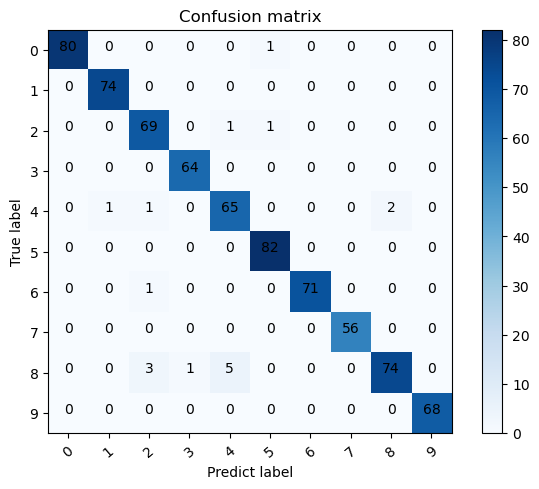

In [17]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))